# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

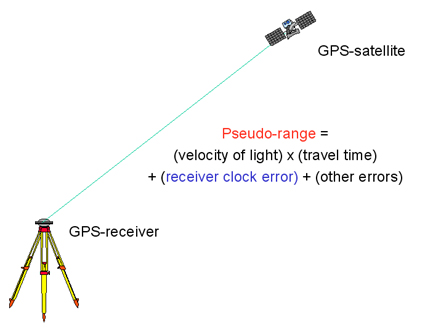

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.1: Import necessary libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [11]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [12]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [13]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [14]:
def euclidean_norm(receiver_pos, satellite_pos):
    # Calculate the Euclidean norm (distance) between receiver and satellite positions
    distance = np.linalg.norm(satellite_pos - receiver_pos)
    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [15]:
def cost_function(r_pos, cdT, s_pos, pseudorange):
    residuals = []

    for i in range(len(s_pos)):
        # Predicted pseudorange
        predicted_pseudorange = euclidean_norm(r_pos, s_pos[i]) + cdT

        # Compute residual
        residual = pseudorange[i] - predicted_pseudorange

        # Append squared residual
        residuals.append(residual**2)

    # Sum of squared residuals
    L = np.sum(residuals)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [16]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    n = len(s_pos)
    grad = np.zeros(4)

    for i in range(n):
        # Calculate the geometric distance between receiver and satellite
        geometric_distance = euclidean_norm(r_pos, s_pos[i])

        # Compute residual
        residual = pseudorange[i] - geometric_distance + cdT

        # Directional vector from receiver to satellite
        direction_vector = (r_pos - s_pos[i]) / geometric_distance if geometric_distance != 0 else np.zeros(3)

        # Partial derivatives with respect to x_r, y_r, z_r
        grad[:3] += -2 * residual * direction_vector

        # Partial derivative with respect to cdT
        grad[3] += -2 * residual

    # Return the gradient as a 1D array with four components
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [17]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count, arr_cost, arr_grad, arr_err  # Use global to ensure variables are accessible outside

    # Initialize the estimates as zeros
    X = np.array([0.0, 0.0, 0.0, 0.0])

    # Initialize global tracking variables
    arr_cost = []
    arr_grad = []
    arr_err = []

    for iteration in range(max_iters):
        # Extract current position and clock offset
        r_pos = X[:3]
        cdT = X[3]

        # Compute the current cost
        current_cost = cost_function(r_pos, cdT, sat_pos, pseudorange)

        # Compute the gradient at the current estimates
        grad = gradient(r_pos, cdT, sat_pos, pseudorange)

        # Update estimates using the gradient
        X_new = X - learning_rate * grad

        # Compute the new cost after the update
        new_cost = cost_function(X_new[:3], X_new[3], sat_pos, pseudorange)

        # Append the current cost to arr_cost for tracking
        arr_cost.append(current_cost)

        # Append gradient and error for additional tracking (optional)
        arr_grad.append(grad)
        arr_err.append(np.linalg.norm(X_new[:3] - GroundTruth))  # Error relative to ground truth

        # Break the loop if the improvement is below tolerance (convergence)
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values

In [18]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# Extract optimized receiver position and clock offset from optimized_params
optimized_position = optimized_params[:3]
optimized_cdT = optimized_params[3]

# Calculate the final position error (Euclidean distance from ground truth position)
position_error = np.linalg.norm(optimized_position - GroundTruth)

# Compute the final cost and gradient
final_cost = cost_function(optimized_position, optimized_cdT, sat_pos, pseudorange)
final_gradient = gradient(optimized_position, optimized_cdT, sat_pos, pseudorange)

# Print the requested metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Error:", position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Error: 5.421135242378522
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.19709343841564
Final Gradient Values: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

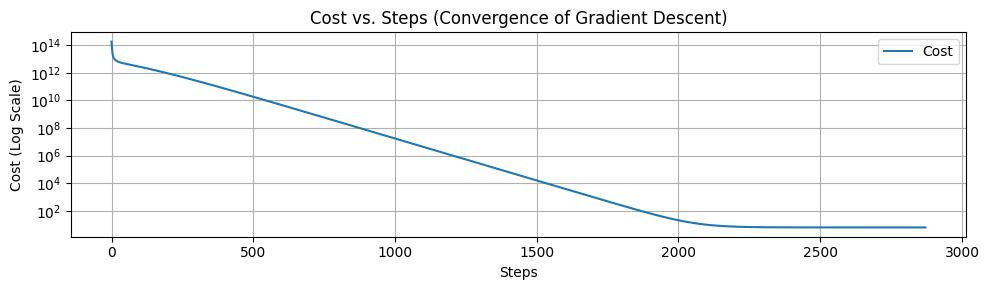

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot cost vs steps with a logarithmic scale on the y-axis
ax.semilogy(arr_cost, label='Cost')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')
ax.set_title('Cost vs. Steps (Convergence of Gradient Descent)')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

NameError: name 'grad_magnitudes' is not defined

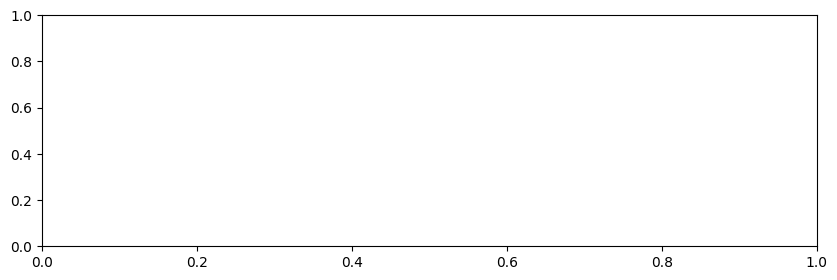

In [20]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot gradient magnitudes vs steps with a symmetric log scale on the y-axis
ax.plot(grad_magnitudes, label='Gradient Magnitude')
ax.set_yscale('symlog')  # Use symmetric log scale for the y-axis
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Magnitude')
ax.set_title('Gradient Magnitude vs. Steps (Convergence of Gradient Descent)')
ax.grid(True)
ax.legend()

# Adjust tick label size for y-axis
ax.tick_params(axis='y', labelsize=8)

fig.tight_layout()
plt.show()
# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot positioning errors vs steps
ax.plot(arr_err, label='Positioning Error')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error (Distance from Ground Truth)')
ax.set_title('Positioning Error vs. Steps (Convergence of Gradient Descent)')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()
# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000)

# Extract optimized receiver position and clock offset
optimized_position_2 = optimized_params_2[:3]
optimized_cdT_2 = optimized_params_2[3]

# Calculate the final position error (Euclidean distance from ground truth)
position_error_2 = np.linalg.norm(optimized_position_2 - GroundTruth)

# Compute the final cost and gradient
final_cost_2 = cost_function(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)
final_gradient_2 = gradient(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

# Print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Error:", position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Error: 5.421135242378522
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.19709343841564
Final Gradient Values: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=200000)

# Extract optimized receiver position and clock offset
optimized_position_3 = optimized_params_3[:3]
optimized_cdT_3 = optimized_params_3[3]

# Calculate the final position error (Euclidean distance from ground truth)
position_error_3 = np.linalg.norm(optimized_position_3 - GroundTruth)

# Compute the final cost and gradient
final_cost_3 = cost_function(optimized_position_3, optimized_cdT_3, sat_pos, pseudorange)
final_gradient_3 = gradient(optimized_position_3, optimized_cdT_3, sat_pos, pseudorange)

# Print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
print("Final Position Error:", position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45048680e+00]
Final Position Error: 5.39838427089483
Number of Steps Taken for Convergence: 27145
Final Cost Value: 6.197741842276456
Final Gradient Values: [ 0.0015476   0.00862312 -0.02650245 -0.01502497]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)

Q1: Higher learning rate converged way faster but the lower learning rate had lower position error. They had similar cost values.

Q2: LSE provides an EXACT solution in one step (no iteration) but only works for linear problems. GD is for linear and non linear as it uses iteration.
Since this was non-linear, gradient descent was better. The downside is that, since it uses hyperparameters, a lot of fine tuning was needed as the solution would diverge (unstable)

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# display sizes of X and y
print(X.shape)
y.shape

(11055, 30)


(11055, 1)

### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

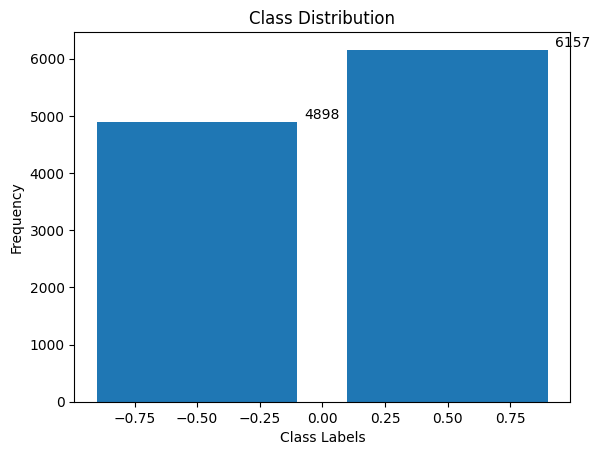

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
# Display exact values for each bin in the histogram
plt.hist(y['result'], bins=2, align='mid', rwidth=0.8) # Access using 'result' (lowercase)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')

# Annotate each bar with its count
for i, count in enumerate(np.unique(y['result'], return_counts=True)[1]): # finds the number of counts of each unique value in y
    plt.text(i, count, str(count), ha='center', va='bottom') #labels the top of each bar with the counts

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# prompt: # TO DO: Create a smaller dataset with 3% of the data
# x
# # TO DO: display sizes of X_small and y_small (2 mark)

from sklearn.model_selection import train_test_split

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

# Display sizes of X_small and y_small
print(X_small.shape)
y_small.shape

(331, 30)


(331, 1)

### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:

from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
model = LogisticRegression(max_iter=2000)

# 1. Implement the model with X and y
model.fit(X, y['result']) # Access using 'result' (lowercase)

# 2. Implement the model with the first two columns of X and y
X_first_two = X.iloc[:, :2]
model.fit(X_first_two, y['result']) # Access using 'result' (lowercase)

# 3. Implement the model with X_small and y_small
model.fit(X_small, y_small['result']) # Access using 'result' (lowercase)

LogisticRegression(max_iter=2000)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

# Assuming X, y, X_small, y_small, and the trained model are available from the previous code

# Function to perform evaluation
def evaluate_model(X, y, model, data_description):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_test)


    print(f"\nEvaluation for: {data_description}")
    print("Data size:", X.shape[0])
    print("Number of training samples:", len(X_train))
    print("Number of testing samples:", len(X_test))
    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Log Loss (Training):", log_loss(y_train, y_train_prob))
    print("Log Loss (Testing):", log_loss(y_test, y_test_prob))


# Evaluate the model for different datasets

# 1. X and y
evaluate_model(X, y['result'], LogisticRegression(max_iter=2000), "Full Dataset")

# 2. First two columns of X and y
evaluate_model(X.iloc[:, :2], y['result'], LogisticRegression(max_iter=2000), "First Two Columns")

# 3. X_small and y_small
evaluate_model(X_small, y_small['result'], LogisticRegression(max_iter=2000), "Small Dataset")


Evaluation for: Full Dataset
Data size: 11055
Number of training samples: 8844
Number of testing samples: 2211
Training Accuracy: 0.9300090456806874
Testing Accuracy: 0.924468566259611
Log Loss (Training): 0.1781740906409623
Log Loss (Testing): 0.1884425737789789

Evaluation for: First Two Columns
Data size: 11055
Number of training samples: 8844
Number of testing samples: 2211
Training Accuracy: 0.5576662143826323
Testing Accuracy: 0.574400723654455
Log Loss (Training): 0.6809821963696229
Log Loss (Testing): 0.6774413744952312

Evaluation for: Small Dataset
Data size: 331
Number of training samples: 264
Number of testing samples: 67
Training Accuracy: 0.9621212121212122
Testing Accuracy: 0.8805970149253731
Log Loss (Training): 0.1466332115944119
Log Loss (Testing): 0.24442993107860278


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

import pandas as pd

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['Data size', 'Training samples', 'Testing samples', 'Training Accuracy', 'Testing Accuracy', 'Log Loss (Training)', 'Log Loss (Testing)'])

# Function to evaluate the model and store results
def evaluate_and_store_results(X, y, model, data_description):
    global results # accessing the global 'results' dataframe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_test)

    new_row = pd.DataFrame({
        'Data size': [X.shape[0]],
        'Training samples': [len(X_train)],
        'Testing samples': [len(X_test)],
        'Training Accuracy': [accuracy_score(y_train, y_train_pred)],
        'Testing Accuracy': [accuracy_score(y_test, y_test_pred)],
        'Log Loss (Training)': [log_loss(y_train, y_train_prob)],
        'Log Loss (Testing)': [log_loss(y_test, y_test_prob)]
    })

    global results
    results = pd.concat([results, new_row], ignore_index=True)

# Evaluate the models and store the results
evaluate_and_store_results(X, y['result'], LogisticRegression(max_iter=2000, random_state=0), "Full Dataset")
evaluate_and_store_results(X.iloc[:, :2], y['result'], LogisticRegression(max_iter=2000, random_state=0), "First Two Columns")
evaluate_and_store_results(X_small, y_small['result'], LogisticRegression(max_iter=2000, random_state=0), "Small Dataset")


# Print the results DataFrame
results

<ipython-input-97-7ad272d0d994>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


,Data size,Training samples,Testing samples,Training Accuracy,Testing Accuracy,Log Loss (Training),Log Loss (Testing)
0,11055,7738,3317,0.932282,0.922822,0.176453,0.190326
1,11055,7738,3317,0.562807,0.556828,0.678881,0.683573
2,331,231,100,0.943723,0.910000,0.155237,0.200366


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


Dimension of predicted output: (3317,)

Confusion Matrix:
[[1341  157]
 [  99 1720]]


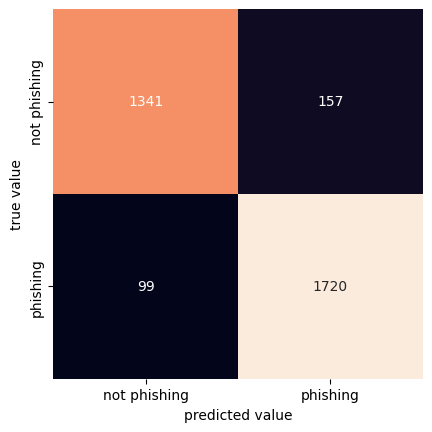

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming X and y are your feature matrix and target vector
X_train, X_test, y_train, y_test = train_test_split(X, y['result'], test_size=0.3, random_state=0)

# Train the model on the training data
model = LogisticRegression(max_iter=2000, random_state=0)
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Print the dimension of the predicted output
print("Dimension of predicted output:", y_pred.shape)

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(conf_mat)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [ ]:
# TO DO: Print classification report (2 marks)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---